## <span style="color:#db7d60">Setup</span>

In [3]:
%load_ext autoreload
%autoreload 2

import json
import math
import pickle
import numpy as np
import pandas as pd
import textwrap
import sys
from pathlib import Path
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

import pandas as pd
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import numpy as np

# pUtil needs to be loaded from the root directory
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))

import pUtil
from analysis_common import *
import data_manager
import analysis as anal

import vector
from particle import Particle
from particle import PDGID

plt.rcParams['figure.figsize'] = (21, 6)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## <span style="color:#db7d60">Analysis</span>

In [4]:
model_names_and_labels = {
    'model_10M_9_exp9_vdimlr_1': '1.47B - 20M',
    'model_exp11_9M_lr1_tp6': '1.47B - 39M',
    'model_exp11_9M_lr1_tp4': '1.47B - 76M',
    'model_exp11_9M_lr1_tp3': '1.47B - 108M',
    'model_exp11_9M_lr1_tp2': '1.47B - 208M',
    # 'model_exp11_9M_lr1_tp5': '1.47B - 611M',
}

(<Figure size 6300x1800 with 1 Axes>,
 <Axes: xlabel='Iteration', ylabel='Validation Loss'>)

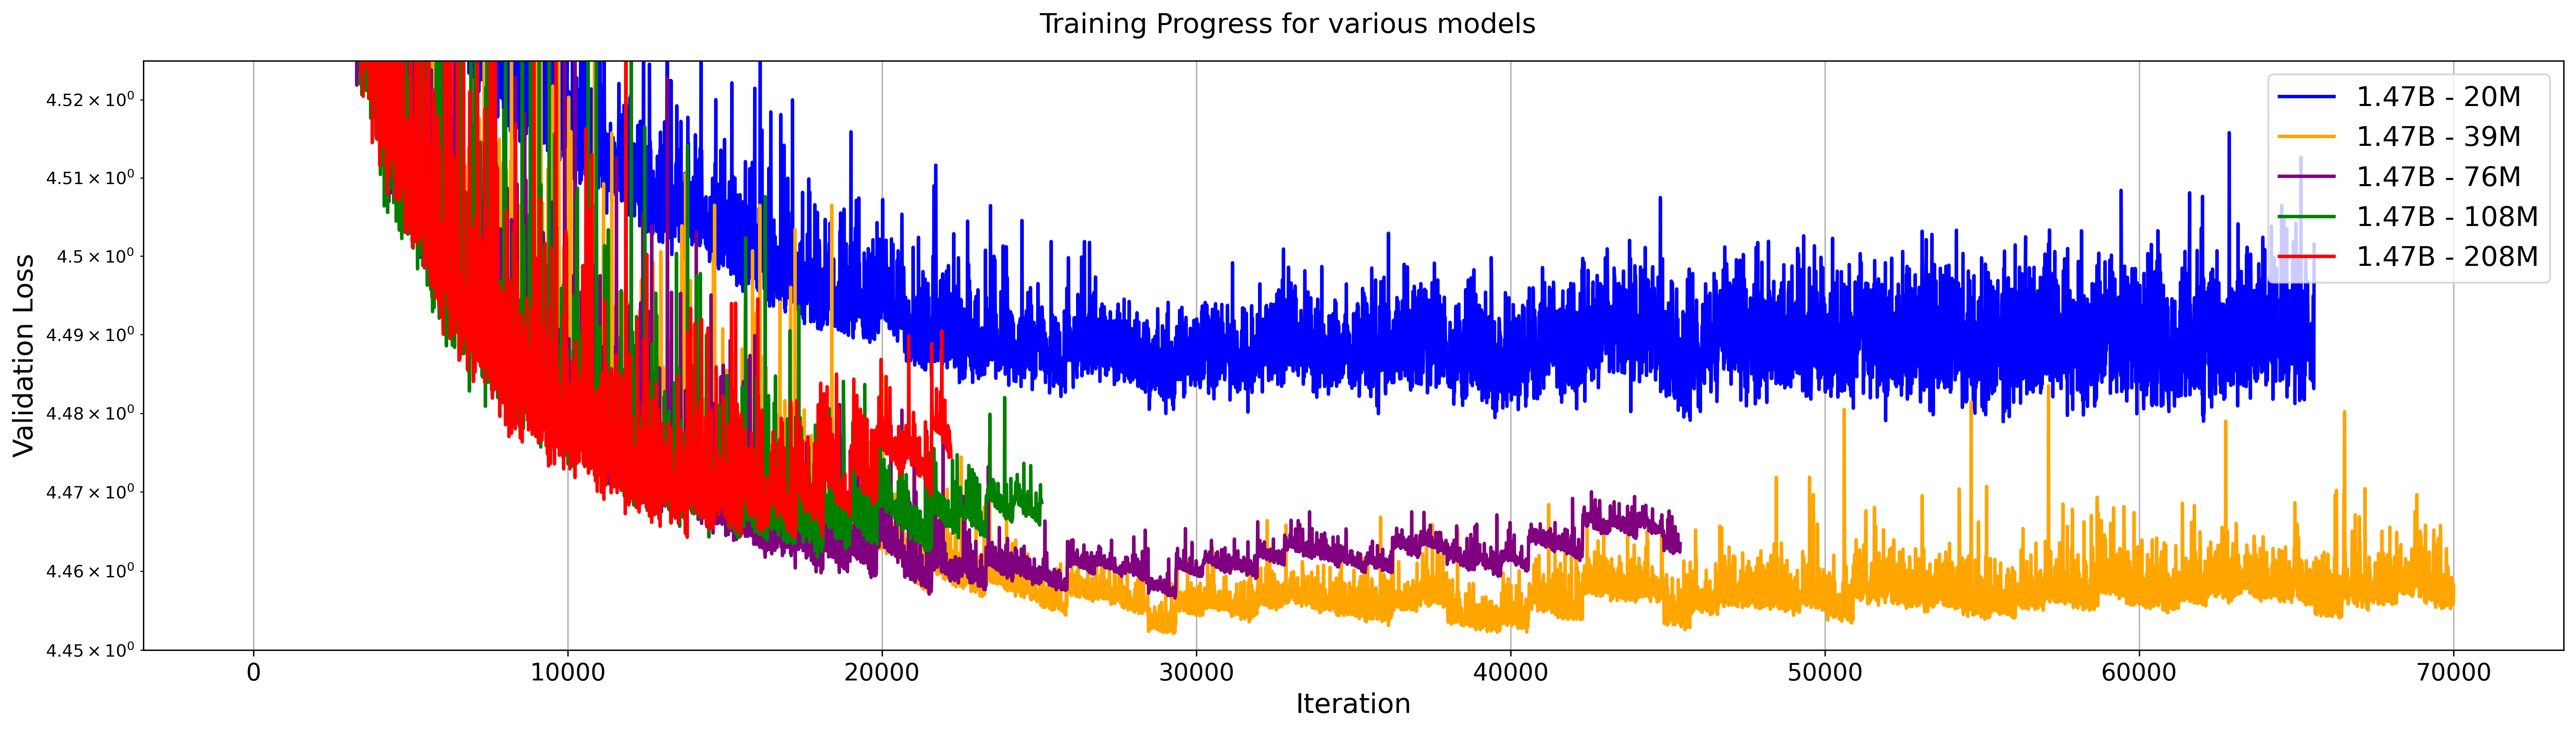

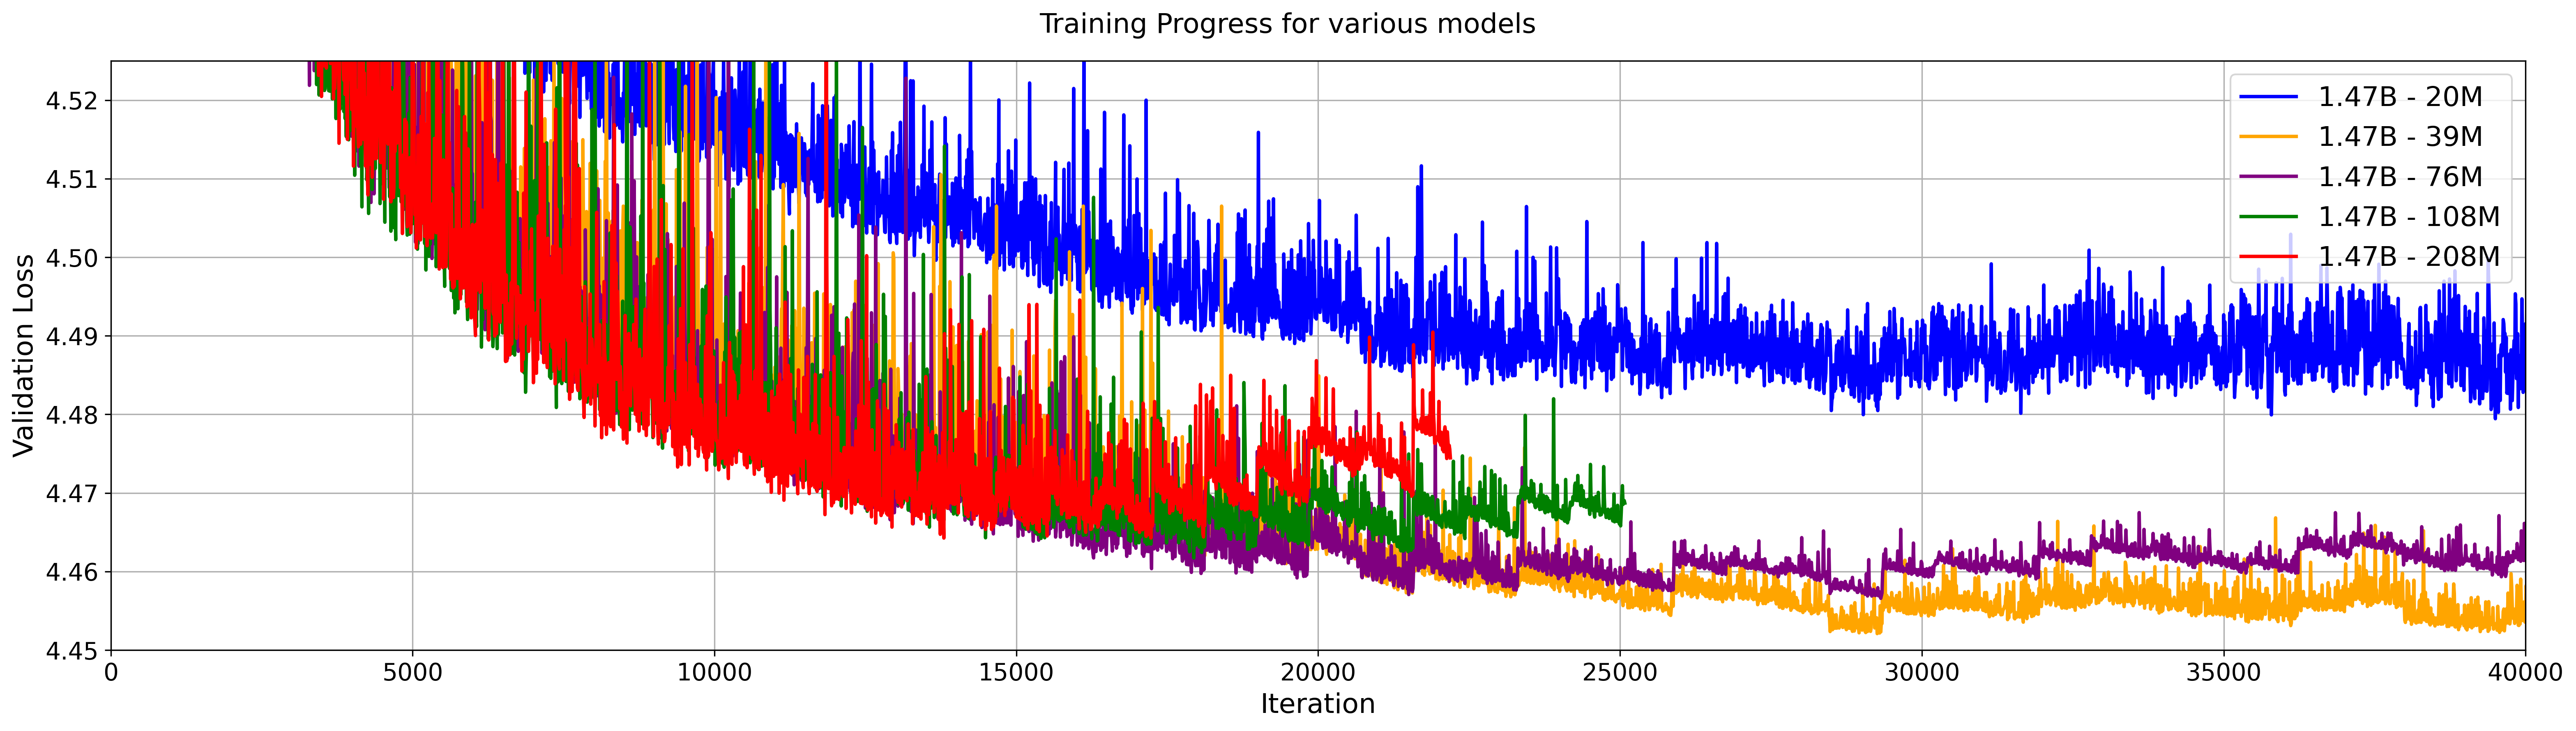

In [5]:
anal.plotting.plot_validation_run(list(model_names_and_labels.keys()), model_legend_titles=list(model_names_and_labels.values()), use_log=True, y_lim=(4.45, 4.525))
anal.plotting.plot_validation_run(list(model_names_and_labels.keys()), model_legend_titles=list(model_names_and_labels.values()), use_log=False, y_lim=(4.45, 4.525), x_lim=(0, 40000))

In [6]:
df = anal.tables.get_default_df(list(model_names_and_labels.keys()))
print("Results sorted by min val loss")
display(df[['model_name', 'iters_saved', 'min_saved_train_loss', 'min_saved_val_loss'] + anal.tables.model_config_columns].sort_values(by='min_saved_val_loss', ascending=True))

Results sorted by min val loss


,model_name,iters_saved,min_saved_train_loss,min_saved_val_loss,batch_size,block_size,learning_rate,min_lr,lr_decay_iters,lr_scheduler,n_layer,n_head,n_embd,num_params
1,model_exp11_9M_lr1_tp6,39250,4.429380,4.452360,128,166,0.001,0.0001,30000,cosine_annealing_with_warmup,10,16,512,39.028736M
2,model_exp11_9M_lr1_tp4,21500,4.429178,4.457072,128,166,0.001,0.0001,30000,cosine_annealing_with_warmup,20,64,512,70.496256M
3,model_exp11_9M_lr1_tp3,21250,4.413840,4.463823,128,166,0.001,0.0001,30000,cosine_annealing_with_warmup,32,128,512,108.25728M
4,model_exp11_9M_lr1_tp2,16250,4.427687,4.465613,128,166,0.001,0.0001,30000,cosine_annealing_with_warmup,64,128,512,208.953344M
0,model_10M_9_exp9_vdimlr_1,39500,4.473144,4.479452,128,166,0.001,0.0001,30000,cosine_annealing_with_warmup,4,2,512,20.148224M


## <span style="color:#db7d60">Equations for validation loss to train tokens</span>

In [8]:
df_simp = df[["model_name", "iters_saved", "min_saved_val_loss", "num_train_tokens"]]
display(df_simp)

,model_name,iters_saved,min_saved_val_loss,num_train_tokens
0,model_10M_9_exp9_vdimlr_1,39500,4.479452,1467326290
1,model_exp11_9M_lr1_tp2,16250,4.465613,1467326290
2,model_exp11_9M_lr1_tp3,8000,4.482161,1467326290
3,model_exp11_9M_lr1_tp4,6750,4.488027,1467326290
4,model_exp11_9M_lr1_tp6,18750,4.463907,1467326290


Pearson

In [9]:
# Correlation
corr, _ = pearsonr(df_simp["num_train_tokens"], df_simp["min_saved_val_loss"])
print(f"Pearson correlation: {corr:.3f}")

Pearson correlation: nan


/tmp/ipykernel_671685/4105494689.py:2: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(df_simp["num_train_tokens"], df_simp["min_saved_val_loss"])


Linear regression

In [11]:
X = np.array(df_simp["num_train_tokens"]).reshape(-1, 1)
y = df_simp["min_saved_val_loss"]

model = LinearRegression().fit(X, y)
print(f"Slope: {model.coef_[0]}, Intercept: {model.intercept_}")

Slope: -1.2879521023728456e-10, Intercept: 4.623254578580437


## <span style="color:#db7d60">Validation Loss vs. Dataset Size</span>

[-0.01829565  0.80941243]


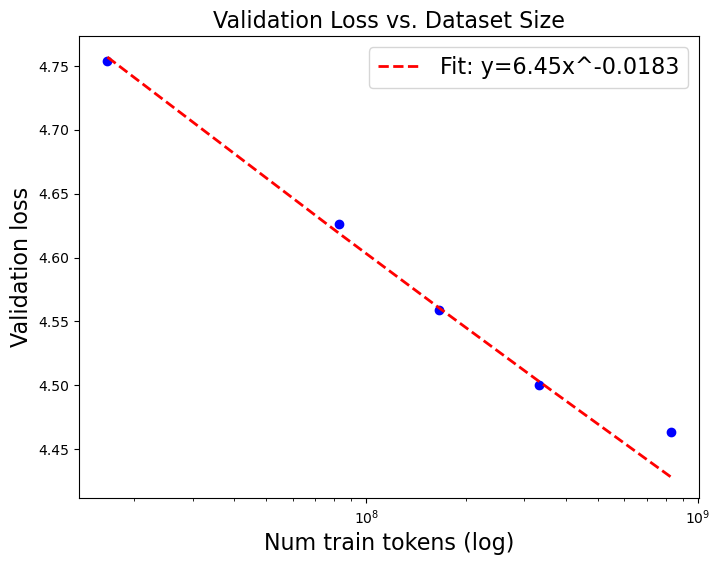

In [12]:
df_plot = df[["model_name", "iters_saved", "min_saved_val_loss", "num_train_tokens"]]
# We remove these models for the following reasons:
# 1) the tp2 models don't really represent the data, we need a separate trainable parameters vs. validation loss curve for them.
# 2) The model_10M_9_exp9_vdimlr_1 model is too much data for the model size, and therefore doesn't accomplish our goal with this plot.
df_plot = df_plot[df_plot["model_name"] != "model_exp11_9M_lr1_tp2"]
df_plot = df_plot[df_plot["model_name"] != "model_exp11_5M_lr1_tp2"]
df_plot = df_plot[df_plot["model_name"] != "model_10M_9_exp9_vdimlr_1"]

x_tokens = df_plot["num_train_tokens"].to_numpy()
y_loss = df_plot["min_saved_val_loss"].to_numpy()

# We remove the last point (the 830M token model) because it is an outlier and messes up the fit.
coefs = np.polyfit(np.log10(x_tokens[:-1]), np.log10(y_loss[:-1]), 1)
p = np.poly1d(coefs)
print(coefs)

plt.figure(figsize=(8, 6))
plt.title("Validation Loss vs. Dataset Size", fontsize=16)
plt.scatter(x_tokens, y_loss, color='blue')
plt.plot(x_tokens, 10**p(np.log10(x_tokens)), linestyle='--', color='red', linewidth=2, label=f"Fit: y={10**coefs[1]:.2f}x^{coefs[0]:.4f}")
plt.xlabel("Num train tokens (log)", fontsize=16)
plt.ylabel("Validation loss", fontsize=16)
plt.xscale('log')
plt.legend(fontsize=16)
plt.show()

[-4.73560969e-04  6.54352876e-01]


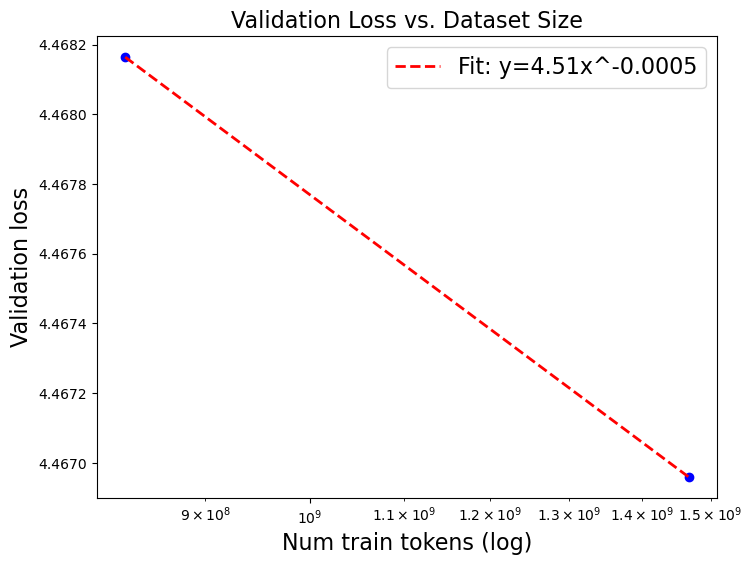

In [13]:
df_plot = df[["model_name", "iters_saved", "min_saved_val_loss", "num_train_tokens"]]
df_plot = df_plot[(df_plot["model_name"] == "model_exp11_9M_lr1_tp2") | (df_plot["model_name"] == "model_exp11_5M_lr1_tp2")]

x_tokens = df_plot["num_train_tokens"].to_numpy()
y_loss = df_plot["min_saved_val_loss"].to_numpy()

coefs = np.polyfit(np.log10(x_tokens), np.log10(y_loss), 1)
p = np.poly1d(coefs)
print(coefs)

plt.figure(figsize=(8, 6))
plt.title("Validation Loss vs. Dataset Size", fontsize=16)
plt.scatter(x_tokens, y_loss, color='blue')
plt.plot(x_tokens, 10**p(np.log10(x_tokens)), linestyle='--', color='red', linewidth=2, label=f"Fit: y={10**coefs[1]:.2f}x^{coefs[0]:.4f}")
plt.xlabel("Num train tokens (log)", fontsize=16)
plt.ylabel("Validation loss", fontsize=16)
plt.xscale('log')
plt.legend(fontsize=16)
plt.show()